<a href="https://colab.research.google.com/github/Michellewang375/t_alltracker/blob/main/computing_PCA_(git).py" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computing the PCA of a Foreground Object
We show in our paper many figures with object parts colored like rainbows. These visualizations are obtained by computing a PCA of patch features on the foreground object. This is what we will compute in this tutorial! Let's start by loading some pre-requisites.

### Setup

Let's start by loading some pre-requisites and checking the DINOv3 repository location:
- `local` if `DINOV3_LOCATION` environment variable was set to work with a local version of DINOv3 repository;
- `github` if the code should be loaded via torch hub.

In [1]:
import pickle
import os
import urllib

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.transforms.functional as TF
from sklearn.decomposition import PCA
from scipy import signal

DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

DINOv3 location set to facebookresearch/dinov3


In [21]:
from dinov3 import DINOv3

model = DINOv3('facebookresearch/dinov3_vits16_pretrain_lvd1689m')
print("DINOv3 loaded successfully!")


ModuleNotFoundError: No module named 'dinov3'

In [ ]:
import os, shutil

# Make the checkpoints folder if it doesn't exist
os.makedirs(os.path.expanduser("~/.cache/torch/hub/checkpoints"), exist_ok=True)

# Move the uploaded file to that folder
shutil.move(
    "dinov3_vits16_pretrain_lvd1689m-08c60483.pth",
    os.path.expanduser("~/.cache/torch/hub/checkpoints/dinov3_vits16_pretrain_lvd1689m-08c60483.pth")
)


'/root/.cache/torch/hub/checkpoints/dinov3_vits16_pretrain_lvd1689m-08c60483.pth'

In [ ]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.1 MB/s eta 0:00:00


### Model Loading
We load the DINOv3 ViT-L model. Feel free to try other DINOv3 models as well!

In [ ]:
# examples of available DINOv3 models:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

MODEL_NAME = MODEL_DINOV3_VITS

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local" if DINOV3_LOCATION != DINOV3_GITHUB_LOCATION else "github",
)
# model.cuda() # Removed this line to run on CPU

Downloading: "https://github.com/facebookresearch/dinov3/zipball/main" to /root/.cache/torch/hub/main.zip


### Loading the Foreground Classifier from the Other Tutorial
For this tutorial, we use the classifier trained in the `foreground_segmentation` notebook. If you haven't already, have a look! Once you have trained your foreground / background classifier on patch features, you should be able to load it here.

In [ ]:
from google.colab import files

# Upload your downloaded .pth file from your local machine
uploaded = files.upload()

Saving fg_classifier.pkl to fg_classifier.pkl


In [ ]:
save_root = '.'
model_path = os.path.join(save_root, "fg_classifier.pkl")
with open(model_path, 'rb') as file:
    clf = pickle.load(file)

### Loading an Image and Applying the Right Transform
Let's load an image and process it in order to make it a multiple of the patch size.

In [ ]:
# PATCH_SIZE = 16
# IMAGE_SIZE = 768

# IMAGENET_MEAN = (0.485, 0.456, 0.406)
# IMAGENET_STD = (0.229, 0.224, 0.225)

# image_uri = "https://dl.fbaipublicfiles.com/dinov3/notebooks/pca/test_image.jpg"

# def load_image_from_url(url: str) -> Image:
#     with urllib.request.urlopen(url) as f:
#         return Image.open(f).convert("RGB")

# # image resize transform to dimensions divisible by patch size
# def resize_transform(
#     mask_image: Image,
#     image_size: int = IMAGE_SIZE,
#     patch_size: int = PATCH_SIZE,
# ) -> torch.Tensor:
#     w, h = mask_image.size
#     h_patches = int(image_size / patch_size)
#     w_patches = int((w * image_size) / (h * patch_size))
#     return TF.to_tensor(TF.resize(mask_image, (h_patches * patch_size, w_patches * patch_size)))


# image = load_image_from_url(image_uri)
# image_resized = resize_transform(image)
# image_resized_norm = TF.normalize(image_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)

In [ ]:
import os
import glob
import torch
import torchvision.transforms.functional as TF
from PIL import Image
import subprocess


PATCH_SIZE = 16
IMAGE_SIZE = 768

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

# GitHub repo
GITHUB_REPO = "https://github.com/Michellewang375/t_alltracker.git"
LOCAL_DIR = "t_alltracker"
IMAGES_DIR = os.path.join(LOCAL_DIR, "dino_img")


if not os.path.exists(LOCAL_DIR):
    subprocess.run(["git", "clone", GITHUB_REPO, LOCAL_DIR], check=True)


def resize_transform(img: Image, image_size=IMAGE_SIZE, patch_size=PATCH_SIZE):
    w, h = img.size
    h_patches = int(image_size / patch_size)
    w_patches = int((w * image_size) / (h * patch_size))
    return TF.to_tensor(TF.resize(img, (h_patches * patch_size, w_patches * patch_size)))

def load_and_preprocess_images(images_dir: str):
    # Grab all png, jpg, jpeg files
    image_paths = sorted(
        glob.glob(os.path.join(images_dir, "*.png")) +
        glob.glob(os.path.join(images_dir, "*.jpg")) +
        glob.glob(os.path.join(images_dir, "*.jpeg"))
    )
    if not image_paths:
        raise FileNotFoundError(f"No images found in {images_dir}")

    processed_images = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        img_resized = resize_transform(img)
        img_resized_norm = TF.normalize(img_resized, mean=IMAGENET_MEAN, std=IMAGENET_STD)
        processed_images.append(img_resized_norm)

    return torch.stack(processed_images)  # shape: (N, 3, H, W)

### Model Forward
Given the input image, we compute local features:

In [ ]:
print("Loading DINOv3 model from torch hub...")
model = torch.hub.load('facebookresearch/dinov3', 'dinov3_vits16')
model.eval()

# Example model selection dictionary
MODEL_TO_NUM_LAYERS = {
    'dinov3_vits16': 12,
    'dinov3_vitsp16': 12,
    'dinov3_vitb16': 12,
    'dinov3_vitl16': 24,
    'dinov3_vithp14': 32,
    'dinov3_vit7b14': 40,
}
MODEL_NAME = 'dinov3_vits16'
n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

# Pick CPU if CUDA is not available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Loading DINOv3 model from torch hub...


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


### Computing Foreground Probability
Let's now pass all those features through our foreground classifier, extract probabilities, and reshape.

In [ ]:
import torch

# Example of loading from torch hub
model = torch.hub.load('facebookresearch/dinov3', 'dinov3_vits16')
model.eval()


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (rope_embed): RopePositionEmbedding()
  (blocks): ModuleList(
    (0-11): 12 x SelfAttentionBlock(
      (norm1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (attn): SelfAttention(
        (qkv): LinearKMaskedBias(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (norm2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
    )
  )
  (norm): LayerN

In [ ]:
# Pick the model string name
MODEL_NAME = 'dinov3_vits16'
model = torch.hub.load('facebookresearch/dinov3', MODEL_NAME)
model.eval()

print(f"Loaded model: {MODEL_NAME}")
print(f"Model embed_dim: {model.embed_dim}")  # Should be 384 for VIT-S/16

# Load images and pick one
images_tensor = load_and_preprocess_images(IMAGES_DIR)
image_resized_norm = images_tensor[4]  # change img number here (0 - first img)

# Pick device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
image_resized_norm = image_resized_norm.to(device)

# Number of layers
MODEL_TO_NUM_LAYERS = {
    'dinov3_vits16': 12,
    'dinov3_vitsp16': 12,
    'dinov3_vitb16': 12,
    'dinov3_vitl16': 24,
    'dinov3_vithp14': 32,
    'dinov3_vit7b14': 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]

# Compute features
with torch.inference_mode():
    autocast_ctx = torch.amp.autocast(
        device_type='cuda' if torch.cuda.is_available() else 'cpu',
        dtype=torch.float32
    )
    with autocast_ctx:
        feats = model.get_intermediate_layers(
            image_resized_norm.unsqueeze(0),
            n=range(n_layers),
            reshape=True,
            norm=True
        )
        x = feats[-1].squeeze().detach().cpu()
        dim = x.shape[0]
        x = x.view(dim, -1).permute(1, 0)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


Loaded model: dinov3_vits16
Model embed_dim: 384


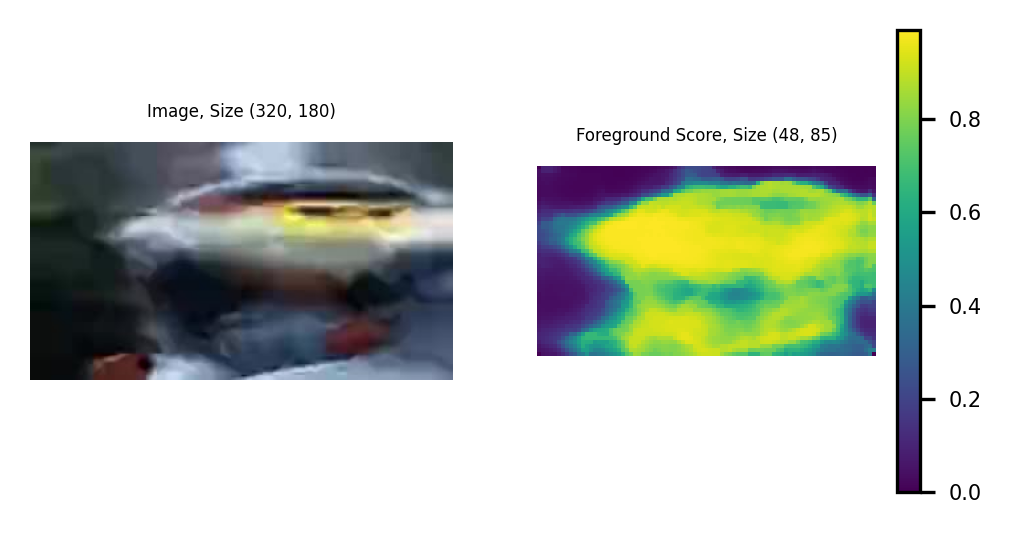

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import glob
from PIL import Image

first_image_path = sorted(
    glob.glob(os.path.join(IMAGES_DIR, "*.png")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.jpg")) +
    glob.glob(os.path.join(IMAGES_DIR, "*.jpeg"))
)[0]


image = Image.open(first_image_path).convert("RGB")


image_resized = images_tensor[4] # change img number here (0 - first img)


h_patches, w_patches = [int(d / PATCH_SIZE) for d in image_resized.shape[1:]]

# Compute foreground score
fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
fg_score_mf = torch.from_numpy(signal.medfilt2d(fg_score, kernel_size=3))

# Plotting
plt.rcParams.update({
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "axes.labelsize": 5,
    "axes.titlesize": 4,
})

plt.figure(figsize=(4, 2), dpi=300)
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title(f"Image, Size {image.size}")

plt.subplot(1, 2, 2)
plt.imshow(fg_score_mf)
plt.title(f"Foreground Score, Size {tuple(fg_score_mf.shape)}")
plt.colorbar()
plt.axis('off')
plt.show()


### Extracting Foreground Patches
We find the patches with positive classifier output, in order to fit the PCA only on the foreground.

In [ ]:
foreground_selection = fg_score_mf.view(-1) > 0.5
fg_patches = x[foreground_selection]

### Fitting the PCA
We use 3 components, and use whitening.

In [ ]:
pca = PCA(n_components=3, whiten=True)
pca.fit(fg_patches)

PCA(n_components=3, whiten=True)

### Applying the PCA, and Masking Background
Finally, we project the features using the PCA, and apply a mask to set the background to black.

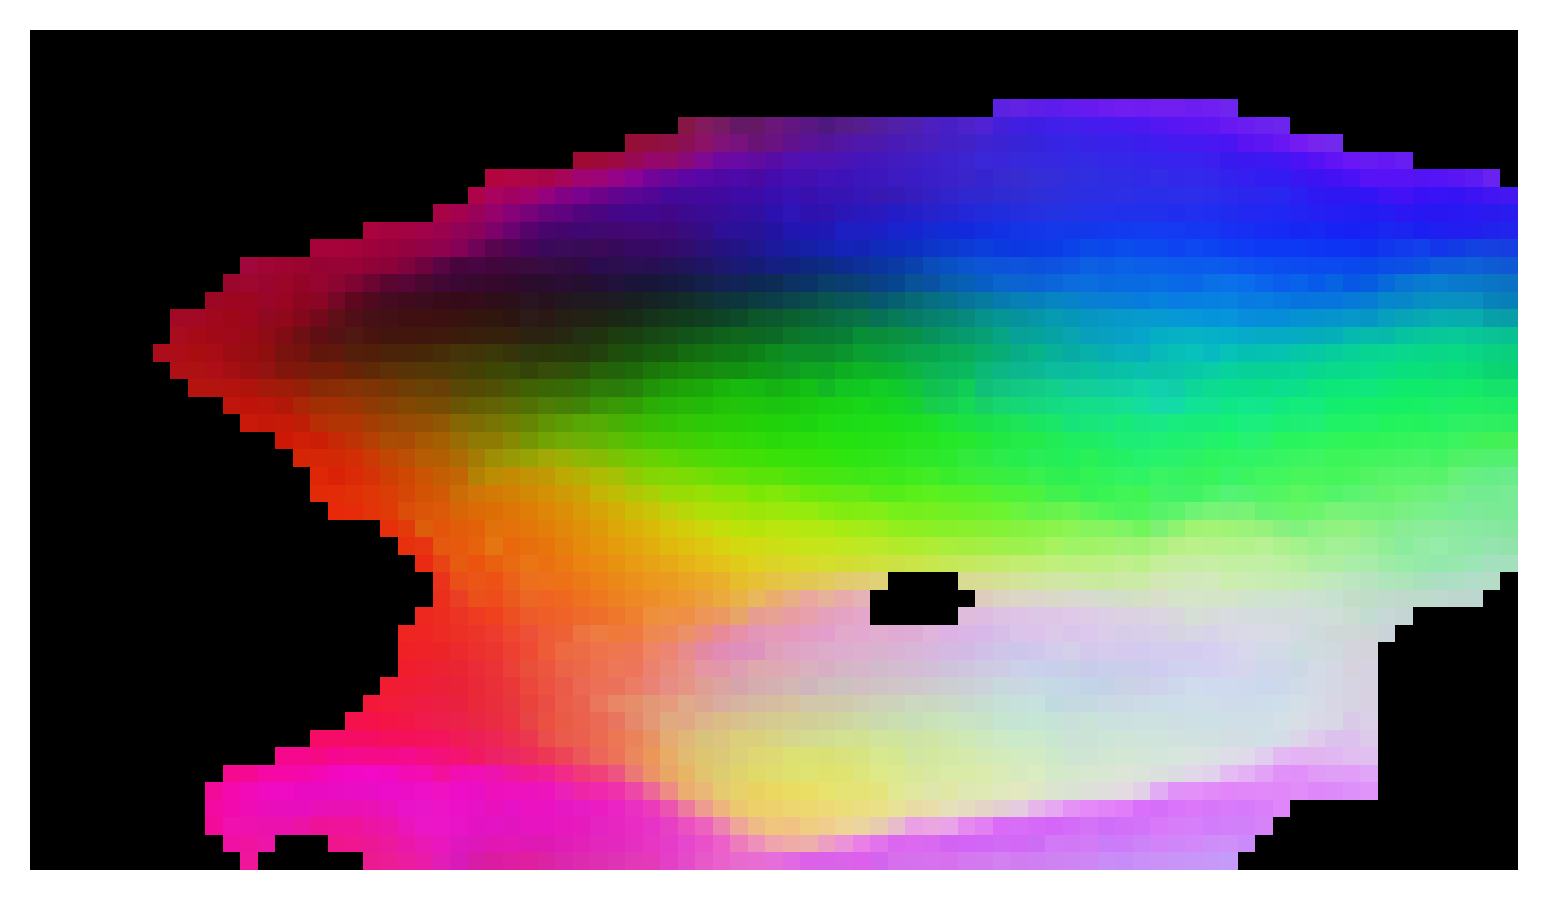

In [ ]:

projected_image = torch.from_numpy(pca.transform(x.numpy())).view(h_patches, w_patches, 3)


projected_image = torch.nn.functional.sigmoid(projected_image.mul(2.0)).permute(2, 0, 1)


projected_image *= (fg_score_mf.unsqueeze(0) > 0.5)

# enjoy
plt.figure(dpi=300)
plt.imshow(projected_image.permute(1, 2, 0))
plt.axis('off')
plt.show()